In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## Get Modified Dataset for Training

In [134]:

# Loading feather files
if True:
    Combined_Feature_train_df = pd.read_feather('Garbage_data/Combined_Feature_train.feather')
    Combined_Feature_val_df = pd.read_feather('Garbage_data/Combined_Feature_val.feather')

In [135]:
if True:
    # Combine train and validation set for cross validation tests

    Full_df = pd.concat((Combined_Feature_train_df, Combined_Feature_val_df), axis=0)
    X_train = Full_df.iloc[:, :-1].values
    y_train = Full_df['label'].values
else:
    # seperate training and validation dataframes between features and labels for manual training

    X_train = Combined_Feature_train_df.iloc[:, :-1].values
    X_val = Combined_Feature_val_df.iloc[:, :-1].values

    y_train = Combined_Feature_train_df['label'].values
    y_val = Combined_Feature_val_df['label'].values

## Pipeline

In [136]:
scaler = StandardScaler()
validation_scores = {}

In [ ]:
# SVM pipeline using one-vs-one organization to do multi-class classification
SVM_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('svc', svm.SVC(kernel='rbf', decision_function_shape='ovo', C=0.5))])

In [138]:
# performs cross validation with our just our training set

train_sizes, train_scores, val_scores = learning_curve(
    SVM_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

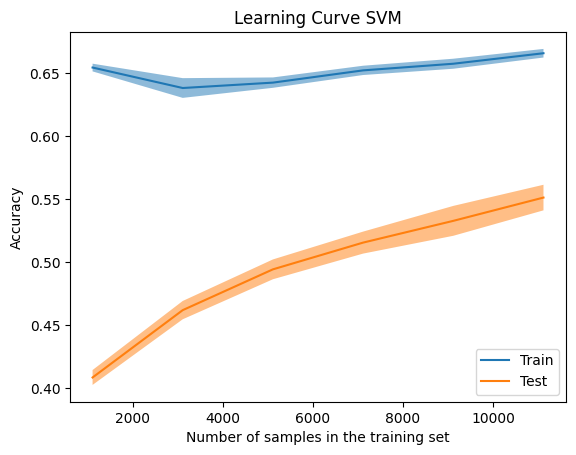

In [139]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)

disp.plot()
plt.title("Learning Curve SVM")
plt.show()

In [140]:
validation_scores['SVM'] = val_scores
val_scores

array([[0.403452  , 0.40215827, 0.41834532, 0.4118705 , 0.40755396],
       [0.45451277, 0.46151079, 0.47482014, 0.4557554 , 0.46402878],
       [0.48399856, 0.4881295 , 0.50647482, 0.49568345, 0.49820144],
       [0.50701187, 0.51258993, 0.52517986, 0.50683453, 0.52697842],
       [0.51743977, 0.53489209, 0.54820144, 0.52158273, 0.54280576],
       [0.53649766, 0.55431655, 0.56007194, 0.54316547, 0.56330935]])

In [150]:
# RandomForest pipeline
RF_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('rf', RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=8))])

In [151]:
# performs cross validation using RandomForest Estimator


train_sizes, train_scores, val_scores = learning_curve(
    RF_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

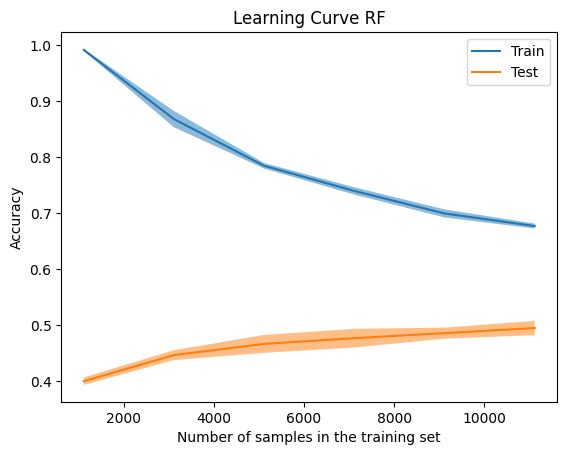

In [152]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)


disp.plot()
plt.title("Learning Curve RF")
plt.show()


In [144]:
validation_scores['RF'] = val_scores
val_scores

array([[0.37216828, 0.36870504, 0.39460432, 0.38561151, 0.37589928],
       [0.38475369, 0.37194245, 0.41402878, 0.38705036, 0.38992806],
       [0.39266451, 0.3676259 , 0.41294964, 0.39748201, 0.39820144],
       [0.39949658, 0.37841727, 0.4176259 , 0.39172662, 0.39532374],
       [0.39374326, 0.37482014, 0.40647482, 0.38597122, 0.39460432],
       [0.39338367, 0.38381295, 0.41654676, 0.39640288, 0.40215827]])

## Confidence Interval

In [ ]:
sample_sizes = np.linspace(0.1, 1.0, 6)


array([ 1112,  3113,  5115,  7116,  9118, 11120])

In [146]:
# Hard code t score from table for 95% confidence
t_score = 2.776


SVM_mean = validation_scores['SVM'].mean(axis=1)
RF_mean = validation_scores['RF'].mean(axis=1)

SVM_std = validation_scores['SVM'].std(ddof=1, axis=1)
RF_std = validation_scores['RF'].std(ddof=1, axis=1)

In [147]:
# Compute the confidence interval
def confidence_interval(mean, std, k, crit_val):
    
    lower = mean - (crit_val * (std/(k**0.5)))
    upper = mean + (crit_val * (std/(k**0.5)))

    return np.array([lower, upper])

In [148]:
for mean, std, sample_size in zip(SVM_mean, SVM_std, sample_sizes):
    SVM_range = confidence_interval(mean = mean, std = std, k =5, crit_val=t_score)
    print(f'Confidence Interval for SVM model with sample size {sample_size:0.2f} and 95% confidence is {SVM_range[0]*100:0.2f}% - {SVM_range[1]*100:0.2f}%')


Confidence Interval for SVM model with sample size 0.10 and 95% confidence is 40.05% - 41.69%
Confidence Interval for SVM model with sample size 0.28 and 95% confidence is 45.20% - 47.22%
Confidence Interval for SVM model with sample size 0.46 and 95% confidence is 48.36% - 50.54%
Confidence Interval for SVM model with sample size 0.64 and 95% confidence is 50.36% - 52.78%
Confidence Interval for SVM model with sample size 0.82 and 95% confidence is 51.65% - 54.94%
Confidence Interval for SVM model with sample size 1.00 and 95% confidence is 53.74% - 56.56%


In [149]:
for mean, std, sample_size in zip(RF_mean, RF_std, sample_sizes):

    RF_range = confidence_interval(mean=mean, std=std, k=5, crit_val=t_score)
    print(f'Confidence Interval for RF model with sample size {sample_size:0.2f} and 95% confidence is {RF_range[0]*100:0.2f}% - {RF_range[1]*100:0.2f}%')


Confidence Interval for RF model with sample size 0.10 and 95% confidence is 36.62% - 39.25%
Confidence Interval for RF model with sample size 0.28 and 95% confidence is 37.05% - 40.86%
Confidence Interval for RF model with sample size 0.46 and 95% confidence is 37.33% - 41.42%
Confidence Interval for RF model with sample size 0.64 and 95% confidence is 37.89% - 41.41%
Confidence Interval for RF model with sample size 0.82 and 95% confidence is 37.66% - 40.56%
Confidence Interval for RF model with sample size 1.00 and 95% confidence is 38.34% - 41.35%
